In [1]:
import pandas as pd
import os
import time

# data science imports
import math
from math import atan2
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

###Import events dataset

shots= pd.read_csv(r'C:\Users\Home\Downloads\ShotData.csv')

C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


<AxesSubplot:xlabel='play_type', ylabel='count'>

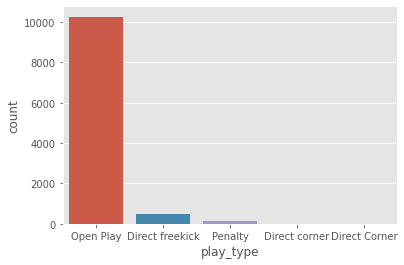

In [2]:
sns.countplot(x='play_type', data=shots)

<AxesSubplot:xlabel='outcome', ylabel='count'>

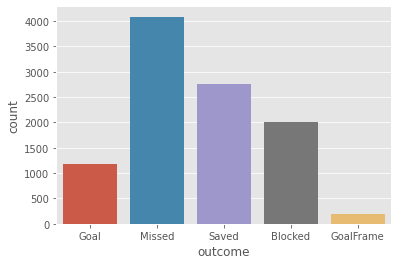

In [3]:
### Open Play Type ###
Open_Play=shots[(shots['play_type']=='Open Play') & (shots['outcome']!='owngoal')].reset_index(drop=True)

Open_Play['BodyPart1']=np.where((Open_Play.BodyPart=='Head')|(Open_Play.BodyPart=='Other'),'Head or Other','Foot')

data = pd.get_dummies(Open_Play, columns=[ 'BodyPart1'])

# creating instance of labelencoder
labelencoder = LabelEncoder()
data['Interference_on_Shooter'] = labelencoder.fit_transform(data['Interference_on_Shooter'])

data['Final_outcome']=np.where((data.outcome=='Goal')|(data.outcome=='GoalFrame'),1,0)
sns.countplot(x='outcome', data=data)

In [4]:
100*Open_Play['BodyPart'].value_counts()/ len(Open_Play['BodyPart'])

Right    49.022101
Left     32.270683
Head     18.110698
Other     0.596519
Name: BodyPart, dtype: float64

In [5]:
100*data['Final_outcome'].value_counts()/ len(data['Final_outcome'])

0    86.583219
1    13.416781
Name: Final_outcome, dtype: float64

In [6]:
##### Adding Distance to the dataset

def add_distance_to_goals(result):

    data['distance_to_goal'] = data[['position_x', 'position_y']].sub(np.array( [0, 0] )).pow(2).sum(1).pow(0.5)

    return(result)

def angle_between(pointA, pointB):
    changeInX = pointB[0] - pointA[0]
    changeInY = pointB[1] - pointA[1]
    return (atan2(changeInY,changeInX)) #remove degrees if you want your answer in radians

data=add_distance_to_goals(data)

data['origin_x']=0
data['origin_y']=0

zipped=list(zip(data['position_x'],data['position_y']))
zipped1=list(zip(data['origin_x'],data['origin_y']))

data['angle']=[angle_between(zipped[i], zipped1[i]) for i in range(len(zipped))]
data1=data.drop(['outcome', 'origin_x', 'origin_y','play_type','BodyPart','match_minute','match_second'], axis=1)

##### Comparing Models without fixing imbalance and choose permutation importance to choose best features ###

In [7]:
# Importing module and initializing setup 

from pycaret.classification import * 

clf1 = setup(data = data1, target = 'Final_outcome',remove_multicollinearity=True,multicollinearity_threshold=0.7,
            normalize=True,normalize_method='minmax',feature_selection=True,
             numeric_features = ['Number_Intervening_Teammates','Number_Intervening_Opponents'])

compare_models()

In [8]:
# Importing module and initializing setup 

from pycaret.classification import * 

clf1 = setup(data = data1, target = 'Final_outcome',remove_multicollinearity=True,multicollinearity_threshold=0.7,
            normalize=True,normalize_method='minmax',feature_selection=True,fix_imbalance=True,
             numeric_features = ['Number_Intervening_Teammates','Number_Intervening_Opponents'])

top3 = compare_models(n_select = 3)

In [9]:
# create a model
gbc = create_model('gbc')

In [10]:
predictions = predict_model(gbc, data = data1)
predictions['Score']=np.where(predictions['Label']==0,1-predictions['Score'],predictions['Score'])

#### Round up the Score and identify probability of both class labels ####

predictions['Score_round'] = round(predictions['Score'],2)
predictions.position_y=predictions.position_y+(min(predictions.position_y)*-1)+10

bins = [0,5, 10, 15, 20,70]
labels = ['0-5','5-10','10-15','15-20','20+']
predictions['Distance_binned'] = pd.cut(predictions['distance_to_goal'], bins=bins, labels=labels)

predictions1=pd.merge(predictions,data[['BodyPart','outcome']],left_index=True,right_index=True)

In [67]:
shots.Number_Intervening_Opponents
predictions1.groupby(['cluster']).mean()

2     3846
3     2634
1     2279
4     1085
5      485
6      260
7      150
0      132
8       46
9        4
10       3
11       1
Name: Number_Intervening_Opponents, dtype: int64

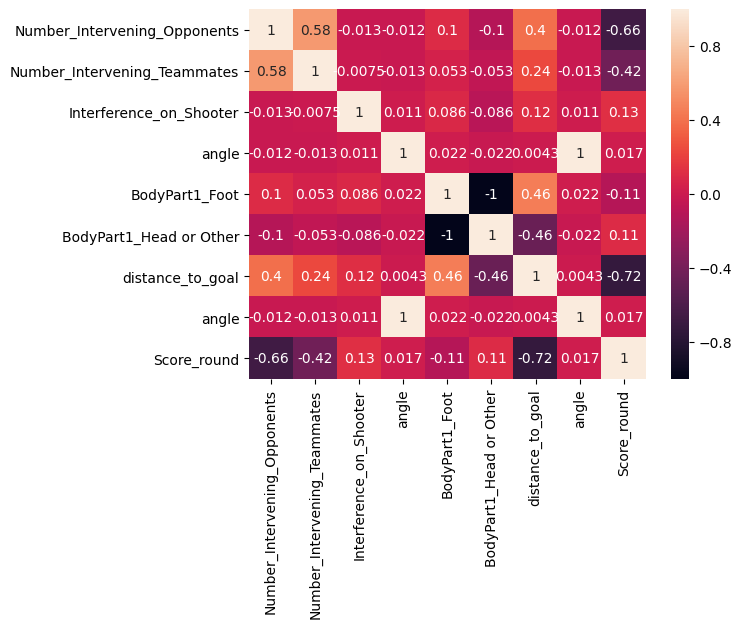

In [69]:
import seaborn as sns
predictions2=predictions1[['Number_Intervening_Opponents','Number_Intervening_Teammates','Interference_on_Shooter','angle',
                           'BodyPart1_Foot','BodyPart1_Head or Other','distance_to_goal','angle','Score_round']]
corrMatrix = predictions2.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

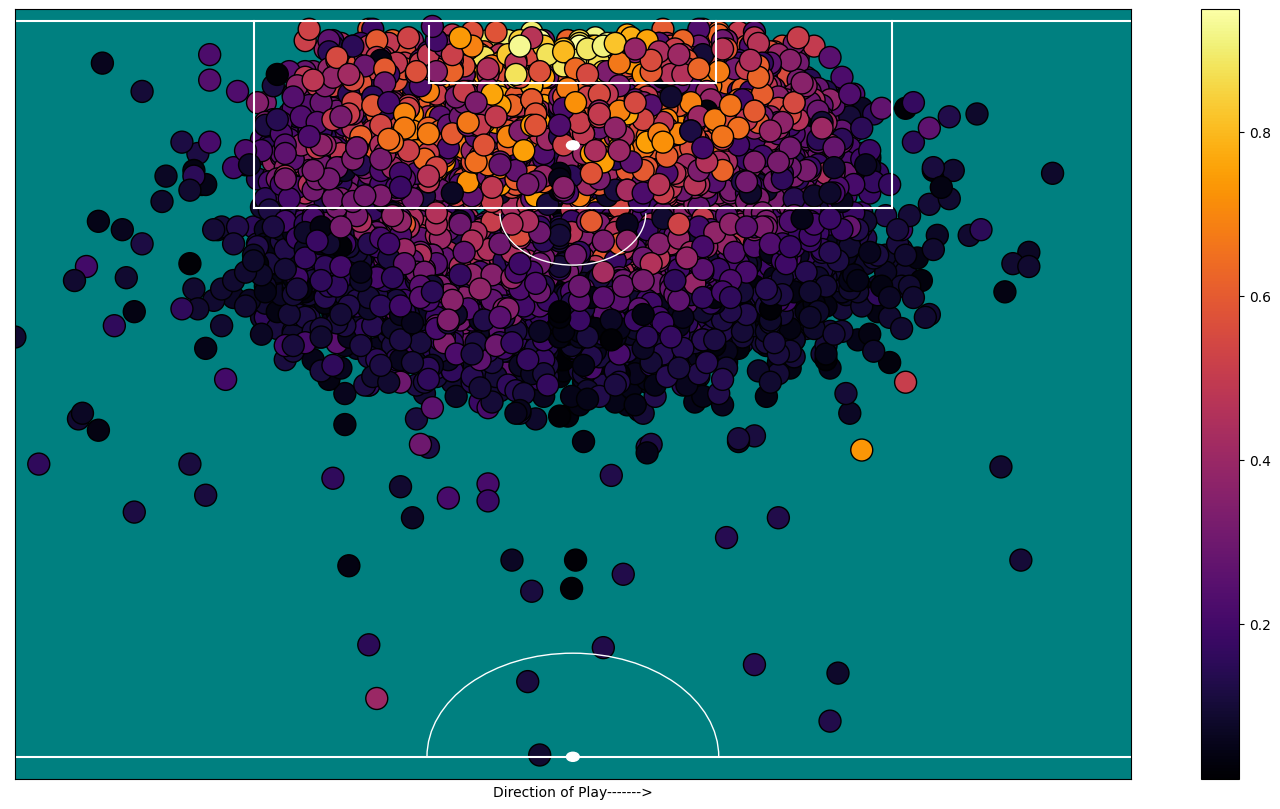

In [61]:
from matplotlib.patches import Arc
import matplotlib.pyplot as plt

#Where does the keeper pass to from Goal Kicks?
#Create figure
fig=plt.figure()
fig.set_size_inches(18, 10)
ax=fig.add_subplot(1,1,1)
plt.style.use(['default'])
ax.set_facecolor('teal')

#Pitch Outline & Centre Line
plt.plot([0,90],[0,0], color="white")
plt.plot([90,90],[0,65], color="white")

plt.plot([0,0],[65,0], color="white")
plt.plot([0,90],[65,65], color="white")


#Left Penalty Area
plt.plot([65,25],[16.5,16.5],color="white")
plt.plot([65,65],[0,16.5],color="white")
plt.plot([25,25],[16.5,0],color="white")

#Left 6-yard Box
plt.plot([54,54],[0,5.5],color="white")
plt.plot([54,36],[5.5,5.5],color="white")
plt.plot([36,36],[5.5,0.5],color="white")

#Prepare Circles
centreSpot = plt.Circle((45,65),0.4,color="white")
leftPenSpot = plt.Circle((45,11),0.4,color="white")
#Prepare Arcs
CentreArc = Arc((45,65),height=18.3,width=18.3,angle=0,theta1=180,theta2=0,color="white",zorder=1)

#Draw Circles
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)

#Draw Arcs
ax.add_patch(CentreArc)


plt.xticks([])
plt.yticks([])



#Prepare Arcs
leftArc = Arc((45,17),height=9.15,width=9.15,angle=0,theta1=360,theta2=180,color="white")

#Draw Arcs
ax.add_patch(leftArc)

x_min=10
x_max=80
y_min=-1
y_max=67

plt.axis([x_min, x_max, y_min, y_max])



plt.xlabel('Direction of Play------->')

#plt.title("Zones leading to Zone 10 (Absorption)",fontsize = 15, y=1.02);#x = GoalKicks_receipts.x.values*1.083
predictions2=predictions1[predictions1['outcome']!='Goal'].reset_index(drop=True)
xe = predictions2.position_x
ye = predictions2.position_y
te=predictions2.Score_round
plt.scatter(ye,xe,c=te,edgecolors="black",zorder=0.2,s=250,cmap='inferno')
plt.colorbar()
plt.gca().invert_yaxis()
#plt.plot(xe,ye,'-p',alpha=0.7,color="white")


plt.show()





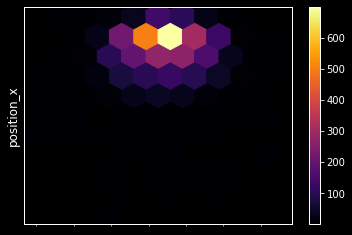

In [30]:
plt.style.use(['dark_background'])
predictions1.plot.hexbin(x='position_y',y='position_x',C='Score_round',reduce_C_function=np.sum,gridsize=10,cmap="inferno")
plt.gca().invert_yaxis()
#Display Pitch

plt.xticks([])
plt.yticks([])
plt.show()

In [147]:
predictions1.to_csv(r'C:\Users\Home\Downloads\predictions1.csv')

In [ ]:
plt.scatter(predictions1.,xe,c=te,edgecolors="black",zorder=0.2,s=250,cmap='inferno')

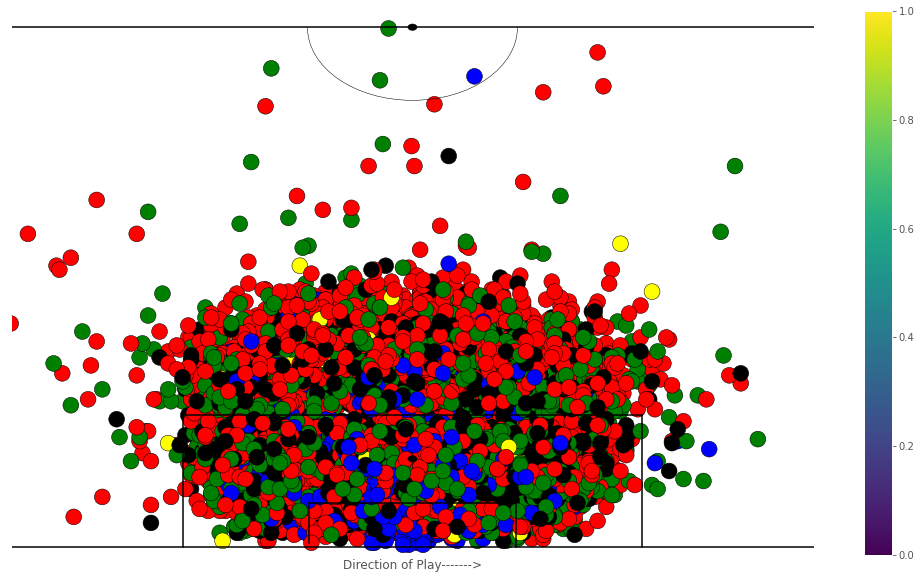

In [186]:
from matplotlib.patches import Arc
import matplotlib.pyplot as plt

#Where does the keeper pass to from Goal Kicks?
#Create figure
fig=plt.figure()
fig.set_size_inches(18, 10)
ax=fig.add_subplot(1,1,1)
ax.set_facecolor('white')

#Pitch Outline & Centre Line
plt.plot([0,90],[0,0], color="black")
plt.plot([90,90],[0,65], color="black")

plt.plot([0,0],[65,0], color="black")
plt.plot([0,90],[65,65], color="black")


#Left Penalty Area
plt.plot([65,25],[16.5,16.5],color="black")
plt.plot([65,65],[0,16.5],color="black")
plt.plot([25,25],[16.5,0],color="black")

#Left 6-yard Box
plt.plot([54,54],[0,5.5],color="black")
plt.plot([54,36],[5.5,5.5],color="black")
plt.plot([36,36],[5.5,0.5],color="black")

#Prepare Circles
centreSpot = plt.Circle((45,65),0.4,color="black")
leftPenSpot = plt.Circle((45,11),0.4,color="black")
#Prepare Arcs
CentreArc = Arc((45,65),height=18.3,width=18.3,angle=0,theta1=180,theta2=0,color="black",zorder=1)

#Draw Circles
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)

#Draw Arcs
ax.add_patch(CentreArc)


plt.xticks([])
plt.yticks([])



#Prepare Arcs
leftArc = Arc((45,17),height=9.15,width=9.15,angle=0,theta1=360,theta2=180,color="black")

#Draw Arcs
ax.add_patch(leftArc)

x_min=10
x_max=80
y_min=-1
y_max=67

plt.axis([x_min, x_max, y_min, y_max])



plt.xlabel('Direction of Play------->')

#plt.title("Zones leading to Zone 10 (Absorption)",fontsize = 15, y=1.02);#x = GoalKicks_receipts.x.values*1.083

xe = predictions1.position_x
ye = predictions1.position_y
colors = {'Goal':'blue', 'Missed':'red', 'Saved':'green', 'Blocked':'black','GoalFrame':'yellow'}
plt.scatter(ye,xe,c=predictions1['outcome'].apply(lambda x: colors[x]),edgecolors="black",zorder=0.1,s=250)

#plt.scatter(ye,xe,c=te,edgecolors="black",zorder=0.2,s=250,cmap='inferno')
plt.colorbar()
#plt.plot([x,xe],[y,ye],alpha=0.7,color="black")
#ax=predictions1.plot.hexbin(x='position_y',y='position_x',C='distance_to_goal',reduce_C_function=np.sum,gridsize=10,cmap="inferno")

#Display Pitch
plt.show()





In [ ]:
colors = {'Goal':'blue', 'Missed':'red', 'Saved':'green', 'Blocked':'black','GoalFrame':'yellow'}
plt.scatter(ye,xe,c=predictions1['outcome'].apply(lambda x: colors[x]),edgecolors="black",zorder=0.1,s=250,cmap='inferno')

colors = {'Head':'blue', 'Left':'red', 'Right':'green', 'Other':'black'}
plt.scatter(ye,xe,c=predictions1['BodyPart'].apply(lambda x: colors[x]),edgecolors="black",zorder=0.1,s=250,cmap='inferno')

In [63]:
predictions1.corr

<bound method DataFrame.corr of        position_x  position_y  Number_Intervening_Opponents  \
0            3.24       43.17                             1   
1           24.94       44.67                             3   
2            3.74       43.42                             1   
3           10.23       48.91                             1   
4           24.19       44.67                             3   
...           ...         ...                           ...   
10221       13.72       48.41                             1   
10222        9.48       50.16                             1   
10223       23.94       36.19                             3   
10224       20.95       52.15                             2   
10225        7.23       48.91                             1   

       Number_Intervening_Teammates  Interference_on_Shooter  BodyPart1_Foot  \
0                                 0                        1               0   
1                                 0                

In [ ]:
print(max(predictions.position_x))
print(max(predictions.position_y))
print(min(predictions.position_x))
print(min(predictions.position_y))

In [ ]:
df.plot.hexbin(x='coord_x',y='coord_y',C='observations',reduce_C_function=np.sum,gridsize=10,cmap="viridis")

In [ ]:
from glue import custom_viewer

from matplotlib.colors import LogNorm

bball = custom_viewer('Shot Plot',
                      x='att(x)',
                      y='att(y)')


@bball.plot_data
def show_hexbin(axes, x, y):
    axes.hexbin(x, y,
                cmap='Purples',
                gridsize=40,
                norm=LogNorm(),
                mincnt=1)


@bball.plot_subset
def show_points(axes, x, y, style):
    axes.plot(x, y, 'o',
              alpha=style.alpha,
              mec=style.color,
              mfc=style.color,
              ms=style.markersize)